# Градиентный спуск своими руками

* Старайтесь сделать код как можно более оптимальным. В частности, не используйте циклы в тех случаях, когда операцию можно совершить при помощи инструментов библиотек.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

In [1]:
# import sys  
# !{sys.executable} -m pip install --user matplotlib

In [2]:
from typing import List, Iterable

import numpy as np
import matplotlib.pyplot as plt

Ниже приведён базовый класс BaseLoss, который мы будем использовать для реализации всех наших лоссов. Менять его не нужно. У него есть два абстрактных метода:

* Метод calc_loss, который будет принимать на вход объекты x, правильные ответы y и веса w и вычислять значения лосса
* Метод calc_grad, который будет принимать на вход объекты x, правильные ответы y и веса w и вычислять значения градиента (вектор)

In [3]:
import abc

class BaseLoss(abc.ABC):
    """Базовый класс лосса"""
    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

### Реализуйте класс MSELoss

Он должен вычислять лосс и градиент

In [4]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        predictions = X @ w
        errors = predictions - y
        res = np.mean(errors**2)
        return res
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        
        n_objects = X.shape[0]
        predictions = X @ w
        errors = predictions - y
        res = (2/n_objects) * (X.T @ errors)
        return res

Теперь мы можем создать объект MSELoss и при помощи него вычислять значение нашей функции потерь и градиенты:

In [5]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(loss.calc_grad(X, y, w), np.array([1163180., 1172281., 1181382., 1190483., 
                                                      1199584., 1208685., 1217786., 1226887., 
                                                      1235988., 1245089.])), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


### Реализуйте функцию gradient_descent

Функция должна принимать на вход начальное значение весов линейной модели w_init, матрицу объектов-признаков X, вектор правильных ответов y, объект функции потерь loss, размер шага lr и количество итераций n_iterations.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из loss посредством вызова метода calc_grad) по формуле выше и возвращать траекторию спуска (список из новых значений весов на каждом шаге)

In [6]:
def gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, n_iterations: int = 100000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    
    lst = []
    w = w_init.copy()
    for i in range(n_iterations):
        lst.append(w.copy())
        w = w - lr * loss.calc_grad(X, y, w)
    
    return lst

In [7]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(42)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [8]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

276.01601930354724
1.0314024162116873


In [9]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(20, 10))
    plt.title("GD trajectory")
    plt.xlabel(r'$w_1$')
    plt.ylabel(r'$w_2$')
    plt.xlim(w_list[:, 0].min() - 0.1, 
             w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1,
             w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect('equal')

    # visualize the level set
    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.colormaps['magma'])
    CB = plt.colorbar(CS, shrink=0.8, extend='both')

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

### При помощи функций gradient_descent и plot_gd нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра lr). Используйте не менее четырёх разных значений для lr.

Сделайте и опишите свои выводы о том, как параметр lr влияет на поведение градиентного спуска

Подсказки:

* Функция gradient_descent возвращает историю весов, которую нужно подать в функцию plot_gd
* Хорошие значения для lr могут лежать в промежутке от 0.0001 до 0.1

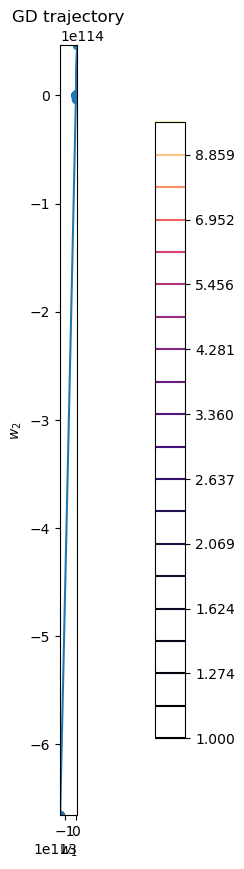

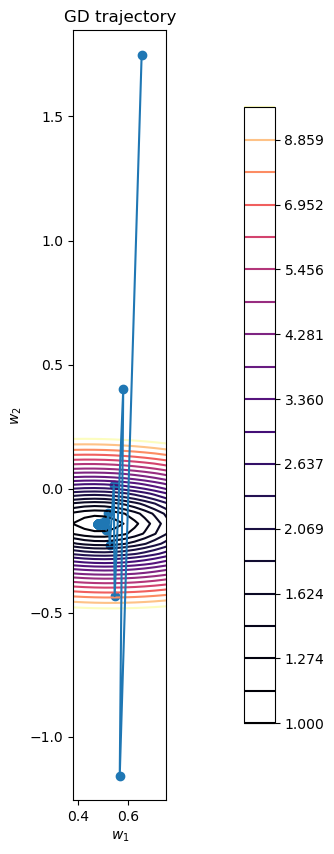

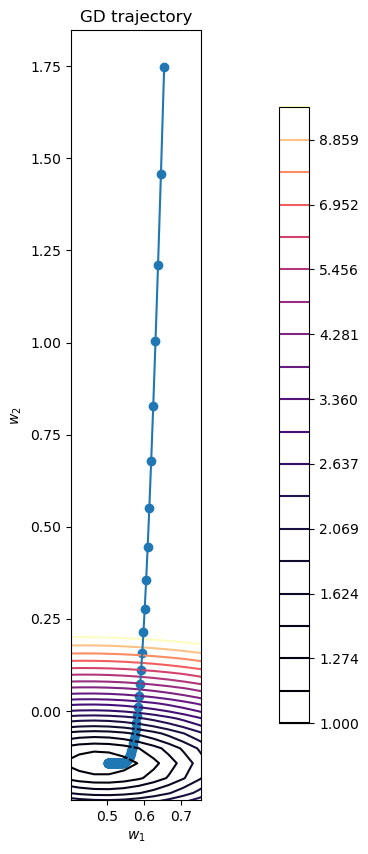

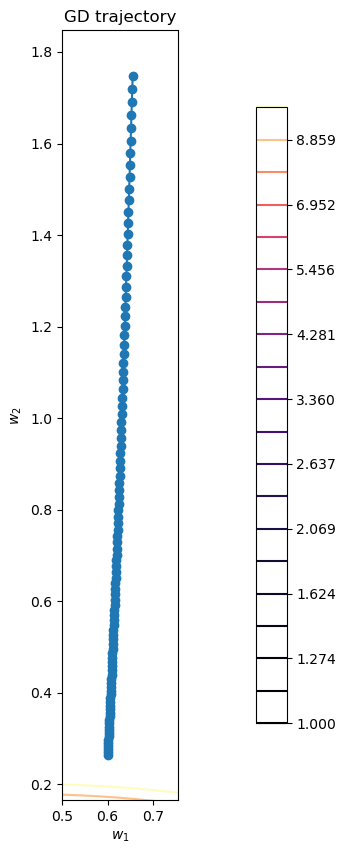

In [10]:
plot_gd(gradient_descent(w_init, X, y, MSELoss(), lr=0.1, n_iterations=100), X, y, MSELoss())
plot_gd(gradient_descent(w_init, X, y, MSELoss(), lr=0.01, n_iterations=100), X, y, MSELoss())
plot_gd(gradient_descent(w_init, X, y, MSELoss(), lr=0.001, n_iterations=100), X, y, MSELoss())
plot_gd(gradient_descent(w_init, X, y, MSELoss(), lr=0.0001, n_iterations=100), X, y, MSELoss())

lr = 0.0001 слишком маленький поэтому за 100 итераций так и не дошло куда надо

lr = 0.001 подошел идеально как будто бы

lr = 0.01 довольно большеват, поэтому градиент прыгает через минимум туда сюда

lr = 0.1 настолько большой, что на графике ничего не понятно, производная улетает в небеса и никогда не придет в минимум 

Чем меньше lr, чем точнее, но тем больше итераций нужно, чтобы прийти в минимум. Нужно соблюдать баланс во вселенной


### *Реализуйте функцию stochastic_gradient_descent¶
Функция должна принимать все те же параметры, что и функция gradient_descent, но ещё параметр batch_size, отвечающий за размер батча.

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке X, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать np.random.choice с правильным параметром size, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив X:

batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)

batch = X[batch_indices]

In [11]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, n_iterations: int = 1000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    
    lst = []
    
    w = w_init.copy()
    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        batchX = X[batch_indices]
        batchY = y[batch_indices]
        
        lst.append(w.copy())
        w = w - lr * loss.calc_grad(batchX, batchY, w)
    
    return lst

### При помощи функций stochastic_gradient_descent и plot_gd нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра lr) и размера подвыборки (параметра batch_size). Используйте не менее четырёх разных значений для lr и batch_size.

Сделайте и опишите свои выводы о том, как параметры lr и batch_size влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что batch_size больше этого числа не будет иметь смысла.

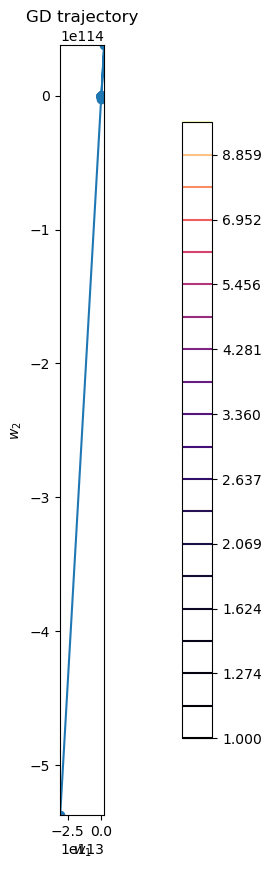

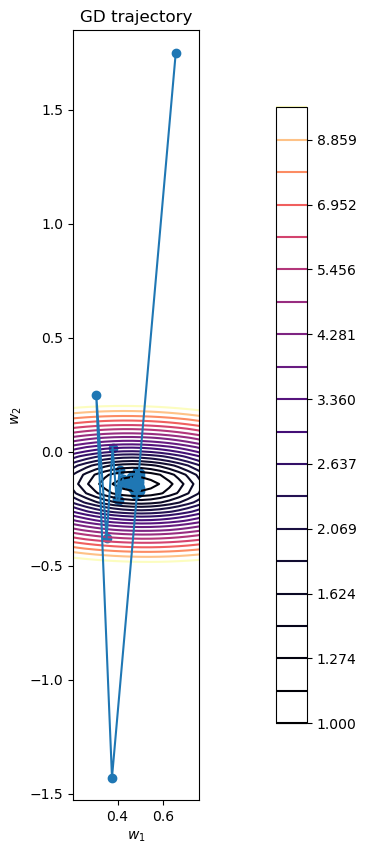

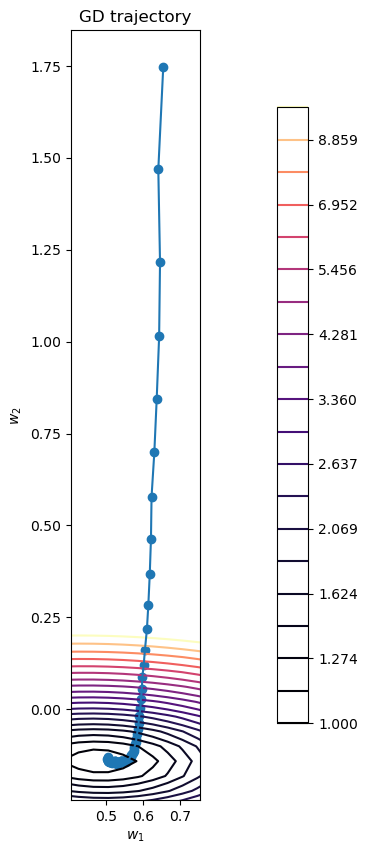

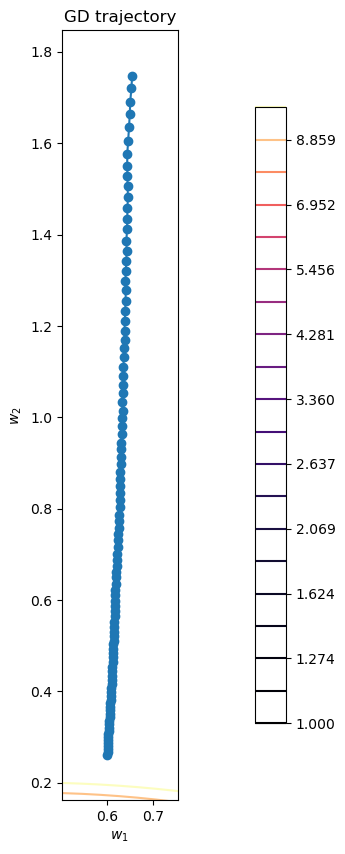

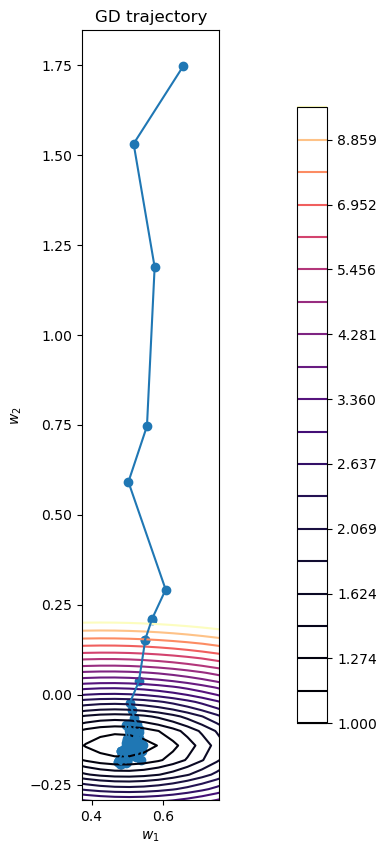

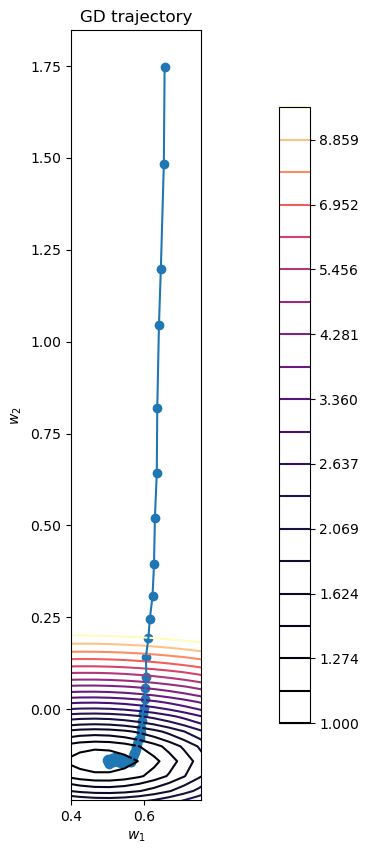

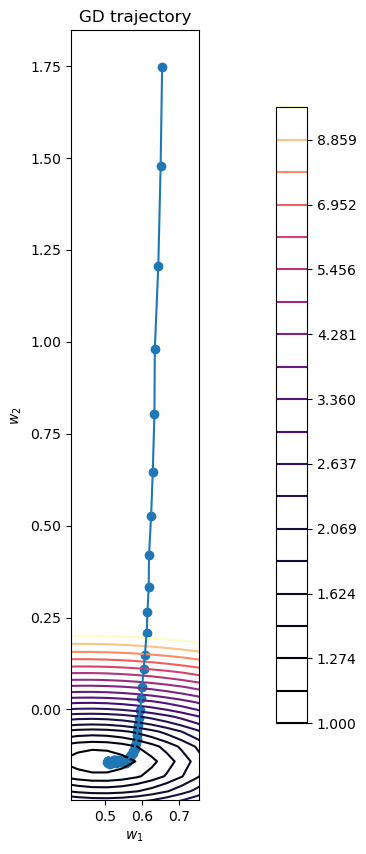

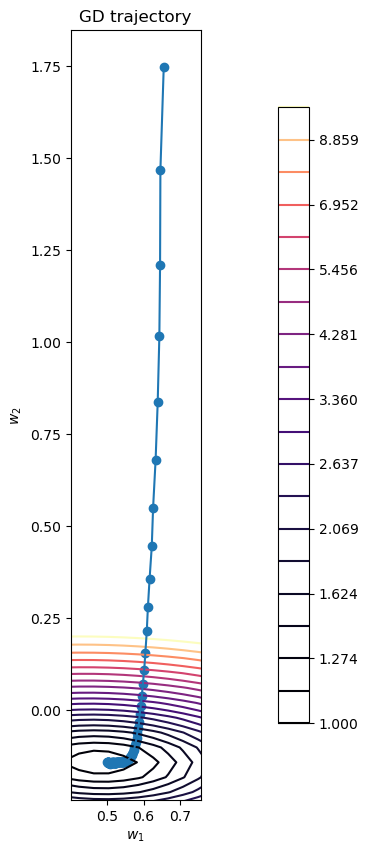

In [12]:
plot_gd(stochastic_gradient_descent(w_init, X, y, MSELoss(), lr=0.1,batch_size=100, n_iterations=100), X, y, MSELoss())
plot_gd(stochastic_gradient_descent(w_init, X, y, MSELoss(), lr=0.01,batch_size=100, n_iterations=100), X, y, MSELoss())
plot_gd(stochastic_gradient_descent(w_init, X, y, MSELoss(), lr=0.001,batch_size=100, n_iterations=100), X, y, MSELoss())
plot_gd(stochastic_gradient_descent(w_init, X, y, MSELoss(), lr=0.0001,batch_size=100, n_iterations=100), X, y, MSELoss())

plot_gd(stochastic_gradient_descent(w_init, X, y, MSELoss(), lr=0.001,batch_size=1, n_iterations=100), X, y, MSELoss())
plot_gd(stochastic_gradient_descent(w_init, X, y, MSELoss(), lr=0.001,batch_size=50, n_iterations=100), X, y, MSELoss())
plot_gd(stochastic_gradient_descent(w_init, X, y, MSELoss(), lr=0.001,batch_size=100, n_iterations=100), X, y, MSELoss())
plot_gd(stochastic_gradient_descent(w_init, X, y, MSELoss(), lr=0.001,batch_size=200, n_iterations=100), X, y, MSELoss())

От размера batch в целом, единственное, что я заметил, точки стали более рандомнее, но свой смысл сохранили, теперь отрабатывают не все точки из размера X и y, а только рандомный, количество которых мы задаем. Чем больше size batch'а, тем точнее, по крайней мере на моих графиках.

P.s. Я художник, я так вижу



# Линейная регрессия
Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки sklearn.

В методе fit мы будем подбирать веса w при помощи градиентного спуска нашим методом gradient_descent

В методе predict мы будем применять нашу регрессию к датасету,

### Допишите код в методах fit и predict класса LinearRegression

В методе fit вам нужно как-то инициализировать веса w, применить gradient_descent и сохранить последнюю w из траектории.

В методе predict вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в self.loss. Его нужно использовать в fit для gradient_descent

In [24]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.001) -> None:
        self.loss = loss
        self.lr = lr
        self.w = None
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LinearRegression':
        n_features = X.shape[1]
        self.w = np.random.randn(n_features)
        w_list = gradient_descent(self.w, X, y, self.loss, self.lr, 1000)
        self.w = w_list[-1]
        
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.dot(X, self.w)

In [25]:
linear_regression = LinearRegression(MSELoss())

In [26]:
# !pip install numpy==1.26.4

In [27]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data", 
    header=None, 
    na_values=["?"]
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [28]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

In [29]:
# !pip install scikit-learn

In [30]:
# import sys  
# !{sys.executable} -m pip install --user scikit-learn

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X_raw = X_raw.drop('index', axis=1) # Удаляем ненужный столбец
df = pd.DataFrame(data=X_raw)
df.info() #Посмотрим где какие признаки
df.isnull().sum() # Посчитаем пустые значения
nans = [1, 18, 19, 21, 22]
for i in nans:
    df[i] = df[i].fillna(df[i].mean()) # Заменяем в вещественных признаках наны на средние
df[5] = df[5].fillna('unknown') #заполнили пропуски и в категориальном признаке
features = [2,3,4,5,6,7,8,14,15,17]
categorical_features = pd.DataFrame(data=df[features]) #отделяем категориальные признаки и удаляем
df = df.drop(features, axis=1)
categorical_features = pd.get_dummies(categorical_features, prefix=features) # one-hot для категориальных
scaler = StandardScaler()
scaler.fit(df)
df = pd.DataFrame(data=scaler.transform(df)) # нормализуем вещ признаки
df = df.merge(categorical_features, left_index=True, right_index=True) # вернули категориальные на место
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size = 0.3, random_state=6)
x_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       201 non-null    int64  
 1   1       164 non-null    float64
 2   2       201 non-null    object 
 3   3       201 non-null    object 
 4   4       201 non-null    object 
 5   5       199 non-null    object 
 6   6       201 non-null    object 
 7   7       201 non-null    object 
 8   8       201 non-null    object 
 9   9       201 non-null    float64
 10  10      201 non-null    float64
 11  11      201 non-null    float64
 12  12      201 non-null    float64
 13  13      201 non-null    int64  
 14  14      201 non-null    object 
 15  15      201 non-null    object 
 16  16      201 non-null    int64  
 17  17      201 non-null    object 
 18  18      197 non-null    float64
 19  19      197 non-null    float64
 20  20      201 non-null    float64
 21  21      199 non-null    float64
 22  22

,0,1,2,3,4,5,6,7,8,9,...,15_twelve,15_two,17_1bbl,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
172,-1.470664,-1.785907,0.595411,0.113819,0.291449,0.464153,-0.274543,-0.117645,-0.077451,0.897977,...,False,False,False,False,False,False,False,True,False,False
84,0.127193,0.093995,-0.412644,-0.146524,-0.233301,-0.887351,-0.295861,-0.407197,-0.601003,0.644218,...,False,False,False,False,False,False,False,False,True,False
181,0.926121,-0.877288,-0.247389,-0.203474,-0.185597,0.791790,-0.666010,-0.431327,-0.526210,0.453899,...,False,False,False,False,False,False,False,True,False,False
51,0.127193,-0.281985,-0.941460,-0.602124,-0.805756,0.136515,-1.173754,-0.865654,-0.937572,-0.339096,...,False,False,False,True,False,False,False,False,False,False
72,0.127193,0.000000,0.644988,0.341619,1.007017,0.423198,0.686681,0.316682,1.680188,-0.434255,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,-1.470664,-0.845956,1.702619,1.187733,1.436357,0.709881,1.281633,0.437329,-1.199348,0.453899,...,False,False,False,False,False,True,False,False,False,False
79,1.725050,0.000000,-0.478746,-0.081438,0.196040,-1.460716,0.537459,0.702751,0.932257,1.913011,...,False,False,False,False,False,False,False,False,True,False
109,-0.671736,1.221936,1.504313,1.016883,1.197835,1.201336,1.349461,0.606234,1.381016,0.834537,...,False,False,False,False,False,True,False,False,False,False
106,-0.671736,0.000000,2.545419,2.009440,1.197835,2.020429,1.306826,-0.165904,0.483498,-0.212217,...,False,False,False,False,False,False,False,True,False,False


### Обучите написанную вами линейную регрессию


In [39]:
loss = MSELoss()
model = LinearRegression(loss=loss, lr=0.01)
model.fit(x_train.values, y_train.values)
y_pred = model.predict(x_test.values)
print(y_pred)

[6376.432327771205 24422.307146153817 17189.706970685405
 6641.9242322649225 15002.592338342421 36355.33766291235 6103.647263447498
 11080.88340123346 18246.328987365723 18824.1043379212 10544.798299377106
 10865.11463510609 5691.172787507927 6875.930714413473 9676.093006621313
 9059.042167508374 20546.55238046333 10876.718728612293 6669.192393291913
 26015.357480384573 24574.850692894564 7014.299195760892
 6747.7985273011745 13138.245129891087 6336.227605194581 7823.658227987238
 9067.019691665366 10912.671420239592 14929.593133758628
 14103.510946730294 16454.142609733808 9795.563040509973 9307.342606552585
 8696.670089021034 10304.566836183518 20335.96013197931 16299.414445804035
 7349.4687100515985 19018.23556072335 18441.533369575493 10871.93419362599
 16069.071075484628 14280.544524745235 10871.93419362599 29172.98761187369
 35289.513236095496 6390.423364869306 6005.52183348672 7474.985785006673
 6314.904712634323 8594.85087944265 10909.674743610902 11297.428619453658
 12325.6363

### Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода mean_squared_error из sklearn.metrics

In [40]:
from sklearn.metrics import mean_squared_error
y_train_pred = model.predict(x_train.values)
y_test_pred = model.predict(x_test.values)

mse_train = mean_squared_error(y_train, y_train_pred)
print(f'MSE на обучающей выборке: {mse_train}')

mse_test = mean_squared_error(y_test, y_test_pred)
print(f'MSE на тестовой выборке: {mse_test}')

MSE на обучающей выборке: 1837577.1132095605
MSE на тестовой выборке: 5449066.811176417


### Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

In [42]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.):
        """
        :param coef: коэффициент регуляризации 
        """
        self.coef = coef
    
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        # Вычислите значение функции потерь при помощи X, y и w и верните его
        predictions = X @ w
        errors = predictions - y
        res = np.mean(errors**2)
        l2_penalty = self.coef * np.sum(w ** 2)
        return res + l2_penalty
    
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
    
        # Вычислите значение вектора градиента при помощи X, y и w и верните его
        n_objects = X.shape[0]
        predictions = X @ w
        errors = predictions - y
        res = (2/n_objects) * (X.T @ errors)
        l2_grad = 2 * self.coef * w
        return res + l2_grad

### Обучите линейную регрессию и посмотрите что станет с лоссом

In [46]:
model = LinearRegression(loss=MSEL2Loss(coef=0.1), lr=0.01)
model.fit(x_train.values, y_train.values)
y_pred = model.predict(x_test.values)
y_pred

array([5414.4953718663255, 18595.30094273881, 19847.96311310959,
       5330.607393747521, 15902.897816322278, 35082.865785679016,
       4935.780826330486, 7155.9889419975825, 16503.231182408847,
       18298.17126609777, 8792.697356213012, 9833.32040917975,
       6012.991120463833, 6512.505290987761, 9925.295087571176,
       9792.969134995352, 20845.842216560974, 9976.65443271561,
       7701.596101637009, 21479.493424631968, 18635.381783082565,
       5109.371649548644, 5239.181990231493, 14288.806077537112,
       6069.091827983169, 7962.2318655252175, 10184.935495865508,
       9700.464946216634, 21121.625704464706, 15340.31028287755,
       16439.65976539905, 8362.853762358525, 10614.592612419816,
       6512.759511322553, 6294.459184927517, 20652.362326796065,
       13886.8901392908, 5542.087838330326, 22565.71381031078,
       18304.853258149265, 8315.847802158496, 17677.240337859774,
       14739.182687252893, 8315.847802158496, 26203.1985811662,
       31440.84416463322, 6

In [48]:
y_train_pred = model.predict(x_train.values)
y_test_pred = model.predict(x_test.values)

mse_train = mean_squared_error(y_train, y_train_pred)
print(f'MSE на обучающей выборке: {mse_train}')

mse_test = mean_squared_error(y_test, y_test_pred)
print(f'MSE на тестовой выборке: {mse_test}')

MSE на обучающей выборке: 6729388.117079351
MSE на тестовой выборке: 7064803.049962546


### *Попробуйте самостоятельно реализовать какой-то другой лосс и посмотреть что изменится:)